In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/home/n/nichollsh/AGNI/socrates"

In [2]:
# Import system packages
using Printf
using Plots

# Default plotting configuration
default(fontfamily="sans-serif", framestyle=:box, label=nothing, grid=true, guidefontsize=9, titlefontsize=9)

# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.solver as nl
import AGNI.dump as dump
import AGNI.plotting as plotting
import AGNI.setpt as setpt

# Use Normal-level logging from AGNI module
AGNI.setup_logging("",1)

### Define atmosphere parameters

In [3]:
# Configuration options for Trappist-1b
instellation    = 0.000553*3.828e26/(0.01154*1.495979e11)^2
gravity         = 10.80
radius          = 1.116 * 6.37e6
nlev_centre     = 40
p_surf          = 1e3+1     # bar
t_surf          = 1800.0
p_top           = 1e-6      # bar
mole_fractions  = Dict([("CO2", 0.8), ("N2",0.2)])

surface_material = joinpath(ROOT_DIR,"res/surface_albedos/c9mb29.dat")

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit/Dayspring48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/trappist-1.txt");


In [4]:
# Create output directory
output_dir = joinpath(ROOT_DIR,"out")
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [5]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, 0.375, 0.0, 48.19,
                        t_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        thermo_functions=true,
                        flag_rayleigh=true,
                        surface_material=surface_material
                        )
atmosphere.allocate!(atmos, star_file)
;

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 CO2     8.00e-01  
[ INFO  ]       2 N2      2.00e-01  


### Run the model for a high-temperature case
This provides an initial guess from which later simulations will be initialised

In [6]:
atmos.tmp_surf = 1850.0
atmos.tmpl[:] .= 1800
atmos.tmp[:]  .= 1800;

In [7]:
solver_success = nl.solve_energy!(atmos,
                                    sol_type=1,
                                    sens_heat=true,
                                    latent=true,
                                    method=1,
                                    dx_max=200.0,
                                    ls_method=0,
                                    save_frames=false, modplot=1, # disable plotting
                                    conv_atol=0.1
                                    )
println("Solver success? $solver_success")

base_atm = deepcopy(atmos)
;

[ INFO  ]     sol_type = 1 
[ INFO  ]     tmp_surf = 1850.00 K 
[ INFO  ]     step  resid_med    cost     flux_OLR    max(x)    max(|dx|)   flags 
[ INFO  ]        1  -8.38e+03  5.050e+04  3.999e+05  1.819e+03  2.000e+02  C2-Nr 
[ INFO  ]        2  -5.28e+03  2.885e+04  2.567e+05  1.832e+03  2.000e+02  C2-Nr 
[ INFO  ]        3  -3.06e+03  1.461e+04  1.540e+05  1.841e+03  2.000e+02  C2-Nr 
[ INFO  ]        4  -1.71e+03  7.284e+03  9.187e+04  1.846e+03  2.000e+02  C2-Nr 
[ INFO  ]        5  -7.31e+02  2.954e+06  4.656e+04  1.849e+03  2.000e+02  C2-Nr 
[ INFO  ]        6  -2.56e+02  2.708e+07  2.496e+04  1.850e+03  1.801e+02  C2-Nr 
[ INFO  ]        7  -5.40e+01  4.703e+06  1.938e+04  1.850e+03  1.176e+02  C2-Nr 
[ INFO  ]        8  -1.81e+00  9.046e+05  1.826e+04  1.850e+03  8.931e+01  C2-Nr 
[ INFO  ]        9  +2.30e-03  1.737e+05  1.803e+04  1.850e+03  4.127e+01  C2-Nr 
[ INFO  ]       10  +1.61e-03  3.326e+04  1.801e+04  1.850e+03  1.924e+01  C2-Nr 
[ INFO  ]       11  +2.17e-05  6.

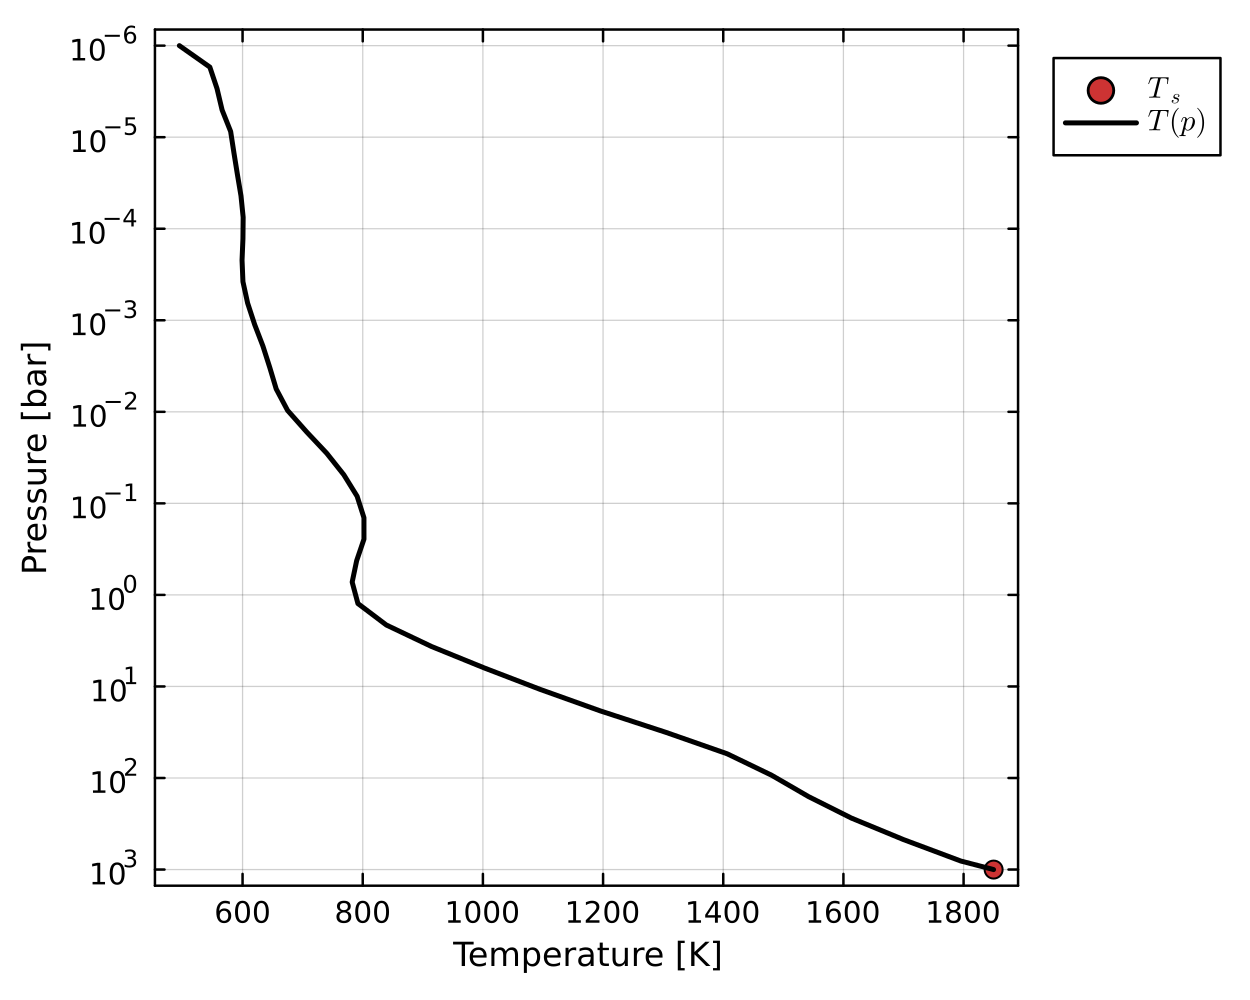

In [8]:
plotting.plot_pt(atmos, joinpath(output_dir,"base_atm.pdf"))

### Run the model for a range of surface pressures
Note that the solver will not print each step to the notebook, to avoid clutter here.

In [9]:
num_loops = 10
prs_arr = range(start=3, stop=-1, length=num_loops)  # log bar
atm_arr = atmosphere.Atmos_t[]

@printf("Running model for %d samples... \n", num_loops)

atmos = deepcopy(base_atm)

for (i,prs) in enumerate(prs_arr)
    # Set new surface pressure
    bar = 10.0^prs
    atmos.p_boa = 1.0e5 * bar
    @printf("Running model for p_surf = %.1f bar \n",bar)

    atmosphere.generate_pgrid!(atmos)

    # Run model
    solver_success = nl.solve_energy!(atmos,
                                    sol_type=3,
                                    sens_heat=true,
                                    latent=false,
                                    method=1,
                                    dx_max=120.0,        # Smaller steps
                                    ls_method=1,
                                    save_frames=false, modplot=1,
                                    modprint=0,
                                    conv_atol=0.1
                                    )

    # Store result
    push!(atm_arr, deepcopy(atmos))

    @printf("--------------------------------- \n")
end
println("Done!")

Running model for 10 samples... 
Running model for p_surf = 1000.0 bar 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     please wait... 
[ INFO  ]     success in 21 steps 
[ INFO  ]     outgoing LW flux   = +1.64e+04 W m-2      
[ INFO  ]     total flux at TOA  = -5.15e-06 W m-2      
[ INFO  ]     total flux at BOA  = -1.21e-08 W m-2      
[ INFO  ]     column max loss    = +2.06e-02 W m-2  (+1.00e+02 %)  
[ INFO  ]     final cost value   = +2.31e-02 W m-2      
[ INFO  ]     surf temperature   = 1360.840  K         
--------------------------------- 
Running model for p_surf = 359.4 bar 
[ INFO  ]     sol_type = 3 
[ INFO  ]     tmp_int  = 0.00 K 
[ INFO  ]     f_int    = 0.00 W m-2 
[ INFO  ]     please wait... 
[ INFO  ]     success in 13 steps 
[ INFO  ]     outgoing LW flux   = +1.64e+04 W m-2      
[ INFO  ]     total flux at TOA  = +3.08e-07 W m-2      
[ INFO  ]     total flux at BOA  = -6.40e-07 W m-2      
[ INFO

### Make plot of temperature profiles

In [10]:
fontsize=12
linewidth=1.5;

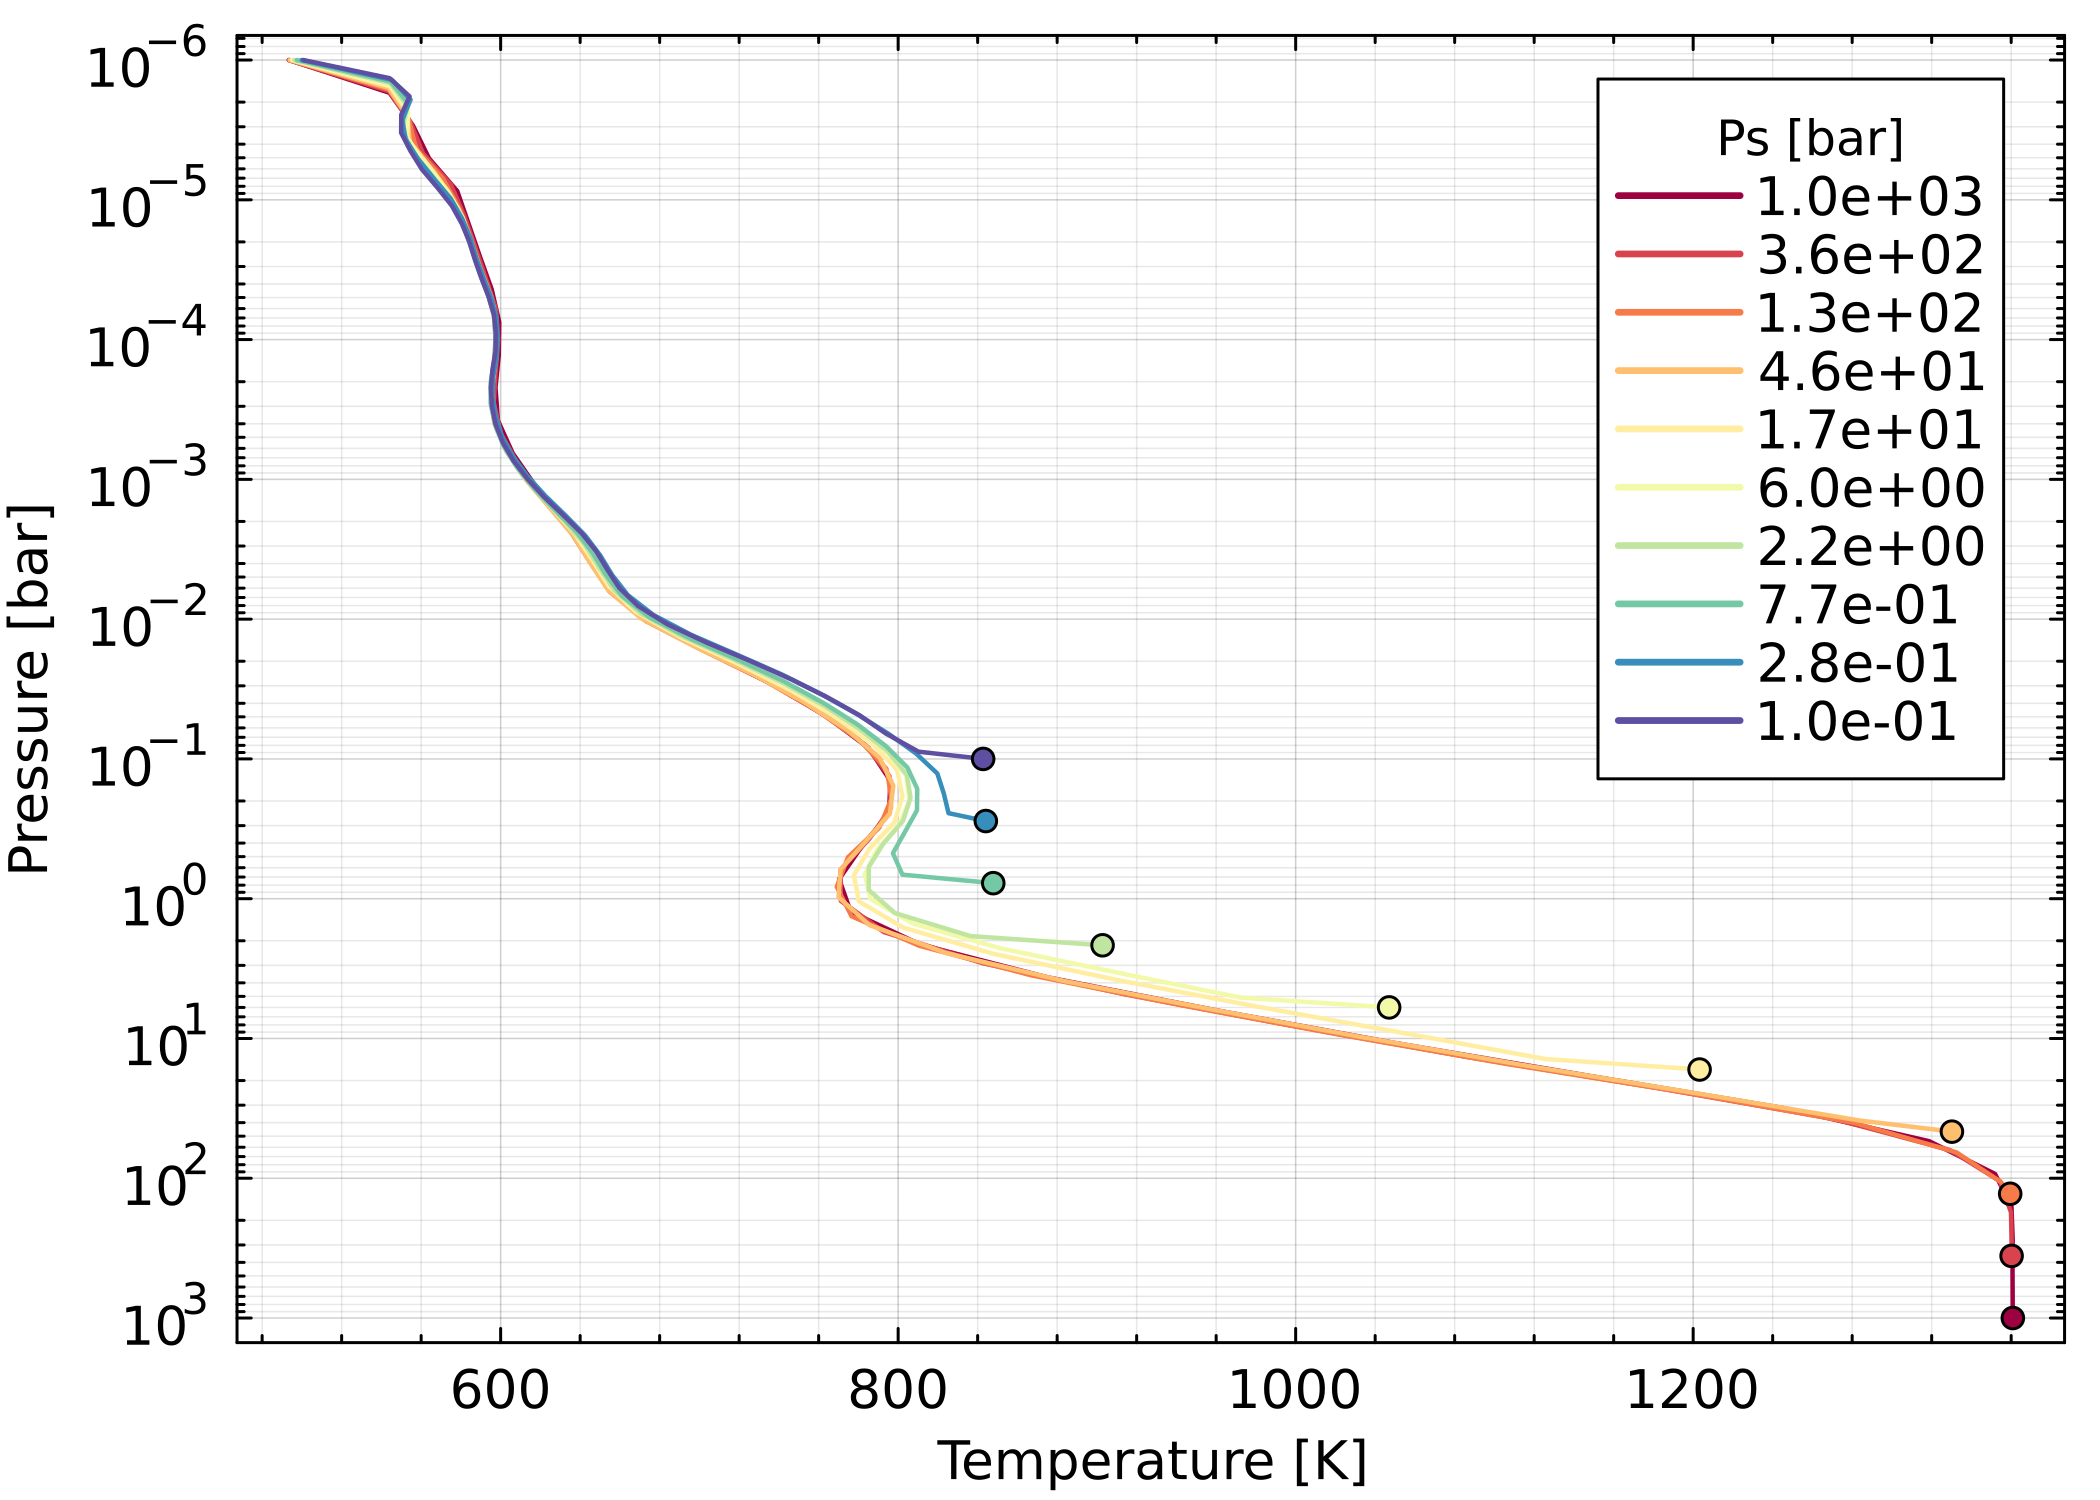

"/home/n/nichollsh/AGNI/out/profile.pdf"

In [11]:
arr_P = atm_arr[1].pl .* 1.0e-5 # Convert Pa to bar
ylims  = (arr_P[1]/1.5, arr_P[end]*1.5)
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

plt = plot(framestyle=:box, size=(700,500), dpi=300,
                leg=:topright, legcolumn=-1,
                tickfontsize=fontsize, guidefontsize=fontsize,
                legendfontsize=fontsize, leg_title="Ps [bar]")

p = Plots.palette(:Spectral, num_loops)
for (i,this_atm) in enumerate(atm_arr)
    plot!(plt, this_atm.tmpl, this_atm.pl* 1.0e-5, lc=p[i], linewidth=linewidth, label=@sprintf("%.1e",this_atm.p_boa*1e-5))
    scatter!(plt, [this_atm.tmpl[end]], [this_atm.pl[end]*1e-5], c=p[i], label="")
end

xlabel!(plt, "Temperature [K]")
xaxis!(plt, minorgrid=true)
ylabel!(plt, "Pressure [bar]")
yflip!(plt)
yaxis!(plt, yscale=:log10, ylims=ylims, yticks=yticks)
display(plt)
savefig(plt,joinpath(output_dir,"profile.pdf"))

### Make plot of F_atm vs surface pressure

In [12]:
# Collect data
olr_arr = Float64[]
for this_atm in atm_arr
    push!(olr_arr, this_atm.flux_u_lw[1])
end


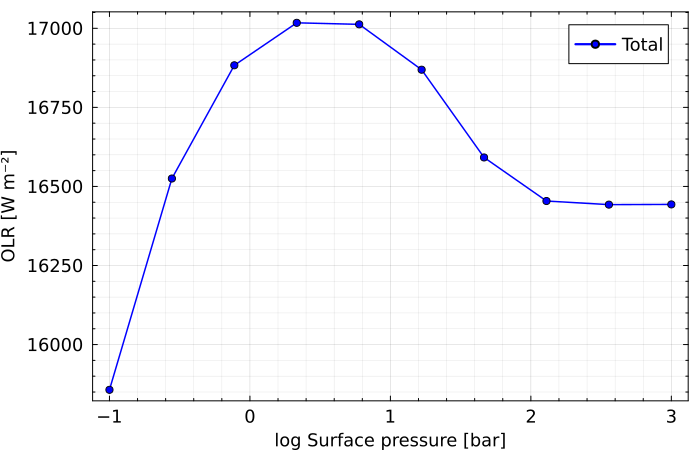

Done!


In [13]:
# Make plot
plt = plot(framestyle=:box, size=(700,450),
            tickfontsize=fontsize, guidefontsize=fontsize, legendfontsize=fontsize)


# Plot curves
marker = (:circle,4)
plot!(plt, prs_arr, olr_arr, linewidth=linewidth, marker=marker, label="Total", color="blue")

# Decorate
xlabel!(plt, "log Surface pressure [bar]")
ylabel!(plt, "OLR [W m⁻²]")
xaxis!(plt, minorgrid=true)
display(plt)
savefig(plt,joinpath(output_dir,"olr.pdf"))
println("Done!")

### Make a plot of emission spectra

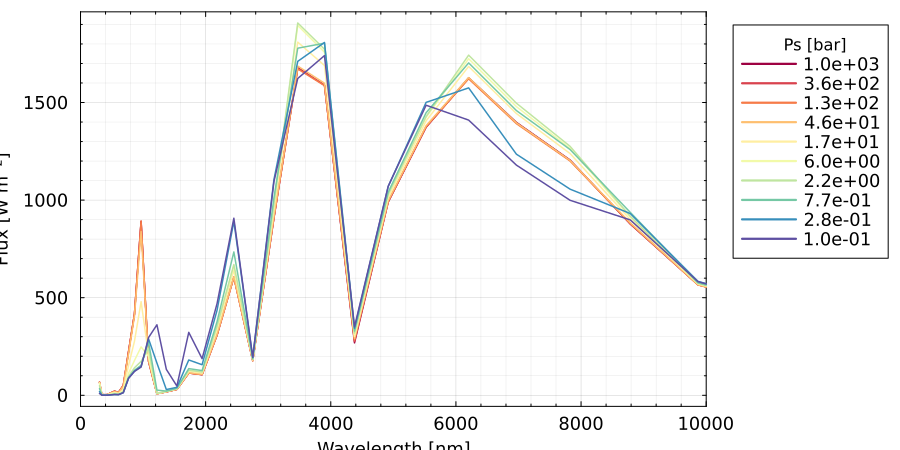

Done!


In [15]:
# Make plot
plt = plot(framestyle=:box, size=(900,450),
            tickfontsize=fontsize, guidefontsize=fontsize, legendfontsize=fontsize,
            xlim=(0, 1e4), legend=:outertopright, legendtitle="Ps [bar]")


p = Plots.palette(:Spectral, num_loops)
for (i,this_atm) in enumerate(atm_arr)
    x = (this_atm.bands_min + this_atm.bands_max) * 0.5 * 1.0e9
    y = this_atm.band_u_lw[1,:] + this_atm.band_u_sw[1,:]
    plot!(plt, x, y, lc=p[i], linewidth=linewidth, label=@sprintf("%.1e",this_atm.p_boa*1e-5))
end


# Decorate
xlabel!(plt, "Wavelength [nm]")
ylabel!(plt, "Flux [W m⁻²]")
xaxis!(plt, minorgrid=true)
display(plt)
savefig(plt,joinpath(output_dir,"emission.pdf"))
println("Done!")